# Sentinel 3 - OLCI Data Download

This notebook presents the tools for the data access and download of Sentinel-3 A/B data OLCI images using the WEkEO API.

## 1. Define Workspace

In [1]:
import base64
import os
import zipfile
import shutil
from dotenv import load_dotenv
load_dotenv()

# API requests config
import requests

# Widgets and maps view
# from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as wg
# from IPython.display import display

In [2]:
cwd = {
    'S3_images': './in/satellite_imagery/S3',
    'EUMETSAT_images': './in/satellite_imagery/EUMETSAT',
    'simile_lakes': './vector/simile_laghi'
}   

## 2. Setup HDA Client

For setting up the credentials for the HDA API, you must edit the `./notebooks/.env` file with you WEkEO user. It is possible to create a user account in the [WEkEO](https://www.wekeo.eu/) platform by going to the **Register** option and complitening the form to create an account

**Warning:** The download of the satellite images using the API is limited on the availability of the server. In case there is no response from the server, it is possible retrieving the images from the [Copernicus Access Hub](https://scihub.copernicus.eu/dhus/#/home).

In [3]:
# Import the credentials from the configuration file in the notebooks directory
url = os.environ['HDA_URL']
user = os.environ['HDA_USER']
password = os.environ['HDA_PASSWORD']

In [4]:
credentials = user+": "+password
credentials_bytes = credentials.encode('ascii')
base64_bytes = base64.b64encode(credentials_bytes)
base64_credentials = base64_bytes.decode('ascii')

Create a string of a call to **GET** /gettoken to get a token. Execute it with os.popen in order to store output as variable

In [5]:
header = {'authorization' : 'Basic '+base64_credentials}
response = requests.get(url+'/gettoken', headers=header)
response = response.json()

Before data can be accessed, the Copernicus Terms and Conditions must be accepted. This needs to be done only once.

In [6]:
header = {
    'accept': 'application/json',
    'authorization' : response['access_token']
}
requests.put(url+'/termsaccepted/Copernicus_General_License', headers=header)

<Response [200]>

In [7]:
parameters = 'url: '+url+'\nuser: '+user+'\npassword: '+password+'\ntoken: '+response['access_token']

In [8]:
# Creation of the client .hdarc config file in the $HOME direcotry used by the hda API library. It is sufficient to run this step once.
with open(os.path.join(os.environ['HOME'],'.hdarc'), 'w') as fp:
    fp.write(parameters)

## 3. Request Sentinel-3 A/B images

In this section, we will review the parameters for the composition of a new request of the satellite images using the [hda API](https://www.wekeo.eu/docs/harmonised-data-access-api).

In [9]:
from hda import Client

In [10]:
#Avoid printing secrets
c = Client()

In [11]:
# Import necessary libraries for the project

# Data
import pandas as pd
import geopandas as gpd

# Plotting
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

Import the reference layer for determining the bound of the query. In this case, it corresponds to the lakes extent.

In [12]:
gdf = gpd.read_file(os.path.join(cwd['simile_lakes'],'como_lugano_maggiore_varese.shp'))

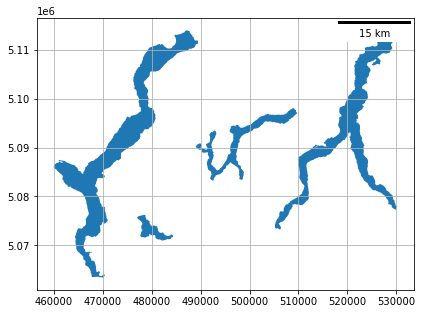

In [13]:
fig, ax = plt.subplots(figsize=(25, 5))
# Plot lakes vector dataset
gdf.plot(ax=ax)
ax.grid()
# Create scale bar
scalebar = ScaleBar(0.001, "km", length_fraction=0.25)
ax.add_artist(scalebar)

In [14]:
# It is necessary to have the query coordinates in web mercator
gdf = gdf.to_crs("EPSG:4326")
# Extract the information from the bounding box of the layer
x_min = min(gdf.bounds['minx'])
x_max = min(gdf.bounds['maxx'])
y_min = min(gdf.bounds['miny'])
y_max = min(gdf.bounds['maxy'])

Define the dictionary with the parameters for the file to import. In this case, the image download refer to the *"OLCI Level 1B Full Resolution - Sentinel-3"* products available through the API. To find more information about the avaliable datasets in the platform you are welcome to visit the [WEkEO data viewer](https://www.wekeo.eu/data?view=viewer). Make sure to specify the dates of interest for the processing.

In [15]:
query = {
  "datasetId": "EO:EUM:DAT:SENTINEL-3:OL_1_EFR___",
  "boundingBoxValues": [
    {
      "name": "bbox",
      "bbox": [
        x_min,
        y_min,
        x_max,
        y_max
      ]
    }
  ],
  "dateRangeSelectValues": [
    {
      "name": "position",
      "start": "2022-11-01T00:00:00.000Z",
      "end": "2022-11-10T00:00:00.000Z"
    }
  ],
  "stringChoiceValues": [
    {
      "name": "platformname",
      "value": "Sentinel-3"
    },
    {
      "name": "producttype",
      "value": "OL_1_EFR___"
    },
    {
      "name": "timeliness",
      "value": "NT"
    }
  ]
}

In [16]:
# The following line runs the query
matches = c.search(query)

# The following line prints the products returned by the query
print(matches)

SearchResults[items=11,volume=6.7G,jobId=JlRyiajZSEa6Xzsk_EP2zW_J1TI]


In [17]:
#The download starts. All the products found in the query are downloaded consecutively
matches.download()

2022-11-10 09:58:32,964 INFO Downloading https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/CfsyWmriTxLIYpOplF4n4TL41tY to S3A_OL_1_EFR____20221108T095427_20221108T095727_20221109T152621_0180_092_022_2160_MAR_O_NT_002.SEN3 (631.3M)
/root/miniconda3/envs/snapEnv/lib/python3.6/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'wekeo-adapter-datastore-k8s.apps.eumetsat.dpi.wekeo.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
2022-11-10 10:01:48,017 WARNING Oops, downloaded 677843028 byte(s), was supposed to be 661956000 (extra 15887028)
2022-11-10 10:01:48,018 INFO Download rate 3.2M/s
2022-11-10 10:01:56,393 INFO Downloading https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/3wTVfc_mdHJdtOffX3W1UNQQHBU to S3B_OL_1_EFR____20221108T091520_20221108T091820_20

In [18]:
for product in matches.__dict__['results']:
    shutil.move(product['filename'], cwd['S3_images'])

**Warning:** Make sure that the folder contains only the compressd filed with the satellite imagery to avoid running into an error.

In [19]:
def extractZipFile(image_dir, file_path):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(image_dir)
        os.remove(file_path)

In [20]:
for root, dirs, files in os.walk(cwd['S3_images']):
    for zip_name in files:
        file_path = os.path.join(root,zip_name)
        print(f'Currently extracting: {zip_name}')
        # Exception required for products retrieved through the HDA API. The products download include the .SEN3 extension and not a compressed file format
        if zip_name.endswith('.SEN3'):
            os.rename(os.path.join(cwd['S3_images'],zip_name),os.path.join(cwd['S3_images'],zip_name.split('.')[0]+'.zip'))
            file_path = os.path.join(cwd['S3_images'],zip_name.split('.')[0]+'.zip')
            extractZipFile(cwd['S3_images'], file_path)
        elif zip_name.endswith('.zip'):
            extractZipFile(cwd['S3_images'], file_path)

Currently extracting: S3A_OL_1_EFR____20221101T093545_20221101T093845_20221102T145625_0179_091_307_2160_MAR_O_NT_002.SEN3
Currently extracting: S3A_OL_1_EFR____20221102T090934_20221102T091234_20221103T143042_0179_091_321_2160_MAR_O_NT_002.SEN3
Currently extracting: S3A_OL_1_EFR____20221104T095811_20221104T100111_20221105T153022_0179_091_350_2160_MAR_O_NT_002.SEN3
Currently extracting: S3A_OL_1_EFR____20221105T093200_20221105T093500_20221106T141811_0179_091_364_2160_MAR_O_NT_002.SEN3
Currently extracting: S3A_OL_1_EFR____20221108T095427_20221108T095727_20221109T152621_0180_092_022_2160_MAR_O_NT_002.SEN3
Currently extracting: S3B_OL_1_EFR____20221102T101126_20221102T101426_20221103T143940_0179_072_179_2160_MAR_O_NT_002.SEN3
Currently extracting: S3B_OL_1_EFR____20221103T094515_20221103T094815_20221104T154434_0179_072_193_2160_MAR_O_NT_002.SEN3
Currently extracting: S3B_OL_1_EFR____20221104T091905_20221104T092205_20221105T145905_0180_072_207_2160_MAR_O_NT_002.SEN3
Currently extracting: S3

# Download EUMETSAT

In [17]:
query = {
  "datasetId": "EO:EUM:DAT:SENTINEL-3:OL_2_WFR___",
  "boundingBoxValues": [
    {
      "name": "bbox",
      "bbox": [
        x_min,
        y_min,
        x_max,
        y_max
      ]
    }
  ],
  "dateRangeSelectValues": [
    {
      "name": "position",
      "start": "2022-10-01T00:00:00.000Z",
      "end": "2022-10-17T23:59:59.999Z"
    }
  ],
  "stringChoiceValues": [
    {
      "name": "sat",
      "value": "Sentinel-3A"
    },
    {
      "name": "timeliness",
      "value": "NT"
    },
    {
      "name": "type",
      "value": "OL_2_WFR___"
    }
  ]
}

In [18]:
# The following line runs the query
matches = c.search(query)

# The following line prints the products returned by the query
print(matches)

SearchResults[items=11,volume=1.9G,jobId=YCM2UAGZzxIVwZ7Ie3uvO9Ur2cs]


In [19]:
#The download starts. All the products found in the query are downloaded consecutively
matches.download()

2022-10-18 10:06:30,573 INFO Downloading https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/g4Ayu3PzVgqUQeMJxBHNLb2Bcc4 to S3A_OL_2_WFR____20221016T095044_20221016T095344_20221017T214616_0179_091_079_2160_MAR_O_NT_003.SEN3 (213.3M)
/root/miniconda3/envs/snapEnv/lib/python3.6/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'wekeo-adapter-datastore-k8s.apps.eumetsat.dpi.wekeo.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
2022-10-18 10:07:17,915 WARNING Oops, downloaded 229048681 byte(s), was supposed to be 223680000 (extra 5368681)
2022-10-18 10:07:17,915 INFO Download rate 4.5M/s
2022-10-18 10:07:25,305 INFO Downloading https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/jqHfnYFdlH7TpKIyUulHPl49ecE to S3A_OL_2_WFR____20221015T101655_20221015T101955_202

In [20]:
for product in matches.__dict__['results']:
    shutil.move(product['filename'], cwd['EUMETSAT_images'])

In [23]:
for root, dirs, files in os.walk(cwd['EUMETSAT_images']):
    for zip_name in files:
        file_path = os.path.join(root,zip_name)
        print(f'Currently extracting: {zip_name}')
        # Exception required for products retrieved through the HDA API. The products download include the .SEN3 extension and not a compressed file format
        if zip_name.endswith('.SEN3'):
            os.rename(os.path.join(cwd['EUMETSAT_images'],zip_name),os.path.join(cwd['EUMETSAT_images'],zip_name.split('.')[0]+'.zip'))
            file_path = os.path.join(cwd['EUMETSAT_images'],zip_name.split('.')[0]+'.zip')
            extractZipFile(cwd['EUMETSAT_images'], file_path)
        elif zip_name.endswith('.zip'):
            extractZipFile(cwd['EUMETSAT_images'], file_path)

Currently extracting: S3A_OL_2_WFR____20221002T091319_20221002T091619_20221003T203700_0179_090_264_2160_MAR_O_NT_003.zip
Currently extracting: S3A_OL_2_WFR____20221004T100156_20221004T100456_20221005T223128_0179_090_293_2160_MAR_O_NT_003.SEN3
Currently extracting: S3A_OL_2_WFR____20221005T093545_20221005T093845_20221006T214716_0179_090_307_2160_MAR_O_NT_003.SEN3
Currently extracting: S3A_OL_2_WFR____20221006T090934_20221006T091234_20221007T210348_0179_090_321_2160_MAR_O_NT_003.SEN3
Currently extracting: S3A_OL_2_WFR____20221008T095812_20221008T100112_20221009T220617_0179_090_350_2160_MAR_O_NT_003.SEN3
Currently extracting: S3A_OL_2_WFR____20221009T093201_20221009T093501_20221010T204210_0179_090_364_2160_MAR_O_NT_003.SEN3
Currently extracting: S3A_OL_2_WFR____20221012T095428_20221012T095728_20221013T204951_0179_091_022_2160_MAR_O_NT_003.SEN3
Currently extracting: S3A_OL_2_WFR____20221013T092817_20221013T093117_20221014T213930_0179_091_036_2160_MAR_O_NT_003.SEN3
Currently extracting: S3A